<a href="https://colab.research.google.com/github/ikumi233102/SpringTest/blob/main/section_2/02_titanic_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# タイタニック号生存者の予測
「ランダムフォレスト」という機械学習のアルゴリズムにより、タイタニック号の生存者を予測します。  
訓練済みのモデルによる予測結果は、csvファイルに保存して提出します。  

## データの読み込み
タイタニック号の乗客データを読み込みます。  
以下のページからタイタニック号の乗客データをダウロードして、「train.csv」「test.csv」をノートブック環境にアップします。  
https://www.kaggle.com/c/titanic/data

訓練データには乗客が生き残ったどうかを表す"Survived"の列がありますが、テストデータにはありません。  
訓練済みのモデルに、テストデータを入力して判定した結果を提出することになります。  


In [22]:
import numpy as np
import pandas as pd

train_data = pd.read_csv("train.csv")  # 訓練データ
test_data = pd.read_csv("test.csv") # テストデータ

# test.csvの年齢から平均値を求める
age_mean = test_data["Age"].mean()
test_data["Age"] = test_data["Age"].fillna(age_mean)
# 平均年齢を表示する
print(age_mean)

#年齢の値が欠損しているデータは平均年齢を入れる
test_data["Age"] = test_data["Age"].fillna(age_mean)

# 平均年齢より若い人はSurvivedを1、平均年齢以上の人は0
test_data["Survived"] = np.where(test_data["Age"] < age_mean, 1, 0)

#testdataのPassengerIdとSurvivedとageのみ出力
print(test_data[["PassengerId", "Survived", "Age"]])

#train_data.head()

30.272590361445783
     PassengerId  Survived       Age
0            892         0  34.50000
1            893         0  47.00000
2            894         0  62.00000
3            895         1  27.00000
4            896         1  22.00000
..           ...       ...       ...
413         1305         0  30.27259
414         1306         0  39.00000
415         1307         0  38.50000
416         1308         0  30.27259
417         1309         0  30.27259

[418 rows x 3 columns]


## データの前処理
判定に使用可能なデータのみを取り出し、データの欠損に対して適切な処理を行います。  
また、文字列などのカテゴリ変数に対しては、数値に変換する処理を行います。  

以下のコードでは、訓練データ及びテストデータから判定に使える列のみを取り出しています。

In [23]:
test_id = test_data["PassengerId"]  # 結果の提出時に使用

labels = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]
train_data = train_data[labels + ["Survived"]]
test_data = test_data[labels]

train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


`info()`によりデータの全体像を確認することができます。  
Non-Null Countにより欠損していないデータの数が確認できるので、データの欠損が存在する列を確認しておきます。  

In [4]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
 7   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null

AgeとFare、Embarkedに欠損が存在します。  
AgeとFareの欠損値には平均値を、Embarkedの欠損値には最頻値をあてがって対処します。  

In [5]:
# Age
age_mean = train_data["Age"].mean()  # 平均値
train_data["Age"] = train_data["Age"].fillna(age_mean)
test_data["Age"] = test_data["Age"].fillna(age_mean)

# Fare
fare_mean = train_data["Fare"].mean()  # 平均値
train_data["Fare"] = train_data["Fare"].fillna(fare_mean)
test_data["Fare"] = test_data["Fare"].fillna(fare_mean)

# Embarked
embarked_mode = train_data["Embarked"].mode()  # 最頻値
train_data["Embarked"] = train_data["Embarked"].fillna(embarked_mode)
test_data["Embarked"] = test_data["Embarked"].fillna(embarked_mode)

`get_dummies()`により、カテゴリ変数の列を0か1の値を持つ複数の列に変換します。  

In [6]:
cat_labels = ["Sex", "Pclass", "Embarked"]  # カテゴリ変数のラベル
train_data = pd.get_dummies(train_data, columns=cat_labels)
test_data = pd.get_dummies(test_data, columns=cat_labels)

train_data.head()

,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,False,True,False,False,True,False,False,True
1,38.0,1,0,71.2833,1,True,False,True,False,False,True,False,False
2,26.0,0,0,7.9250,1,True,False,False,False,True,False,False,True
3,35.0,1,0,53.1000,1,True,False,True,False,False,False,False,True
4,35.0,0,0,8.0500,0,False,True,False,False,True,False,False,True


## モデルの訓練
入力と正解を用意します。  
"Survived"の列が正解となります。

In [7]:
t_train = train_data["Survived"]  # 正解
x_train = train_data.drop(labels=["Survived"], axis=1)  # "Survived"の列を削除して入力に
x_test = test_data

ランダムフォレストは、複数の決定木を組み合わせた「アンサンブル学習」の一種です。  
アンサンブル学習は複数の機械学習を組み合わせる手法で、しばしば高い性能を発揮します。  

以下のコードでは、`RandomForestClassifier()`を使い、ランダムフォレストのモデルを作成して訓練します。  
多数の決定木の多数決により、分類が行われることになります。

In [8]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators: 決定木の数  max_depth: 決定木の深さ
model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(x_train, t_train)

RandomForestClassifier(max_depth=5)

## 結果の確認と提出
`feature_importances_`により各特徴量の重要度を取得し、棒グラフで表示します。

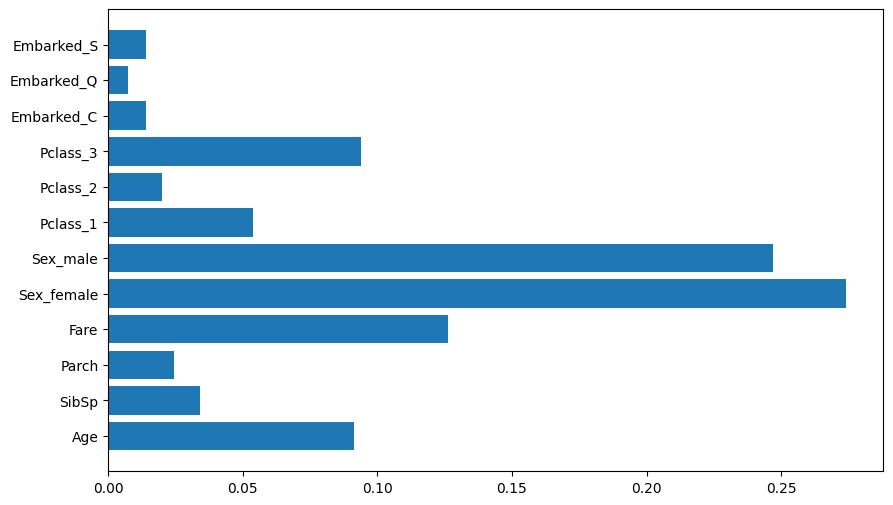

In [9]:
import matplotlib.pyplot as plt

labels = x_train.columns
importances = model.feature_importances_

plt.figure(figsize = (10,6))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(labels)), labels)
plt.show()

テストデータを使って予測を行います。  
予測結果には、分類されるクラスを表す「Label」列と、そのクラスに含まれる確率を表す「Score」ラベルが含まれます。  
形式を整えた上で提出用のcsvファイルとして保存します。

In [10]:
# 判定
y_test = model.predict(x_test)

# 形式を整える
survived_test = pd.Series(y_test, name="Survived")
subm_data = pd.concat([test_id, survived_test], axis=1)

# 提出用のcsvファイルを保存
subm_data.to_csv("submission_titanic.csv", index=False)

subm_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
